In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve,LearningCurveDisplay
from tqdm import tqdm
import os
from sklearn.metrics import f1_score
import seaborn as sns
import cv2
import time
from typing import Any
import json
import re

In [11]:
RANDOM_SEED=42
IMAGE_SIZE=(64,64)
COLORS = {
    "kNN": 'red',
    'SVM': 'blue',
    'NN': 'green'
}
DATASET_NAME = "realwaste"

In [5]:
def load_images_from_nested_folder(folder, image_size):
    images = []
    labels = []
    class_names = []
    class_idx = 0

    for class_folder in tqdm(os.listdir(folder)):
        class_path = os.path.join(folder, class_folder)
        if not os.path.isdir(class_path):
            continue

        class_names.append(class_folder)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                images.append(img.flatten())
                labels.append(class_idx)
        
        class_idx += 1
    print(f"Loaded {len(images)} images.")
    return np.array(images), np.array(labels), class_names

X, y, class_names = load_images_from_nested_folder("realwaste-main/RealWaste", image_size=IMAGE_SIZE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:09<00:00,  1.02s/it]

Loaded 4752 images.


In [81]:
def run_grid_search(estimator, param_grid, X, y):
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3, scoring="f1_weighted",n_jobs=-1,verbose=3)
    grid_search.fit(X, y)

    # Extract the results from grid search
    results = grid_search.cv_results_
    
    return pd.DataFrame(results)

def run_knn(X, y):
    param_grid = {
        'n_neighbors': [1,3,5,10,25,50, 100],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    knn = KNeighborsClassifier(n_jobs=-1)
    df = run_grid_search(knn, param_grid, X, y)
    return df

def run_nn(X, y):
    param_grid = {
        'hidden_layer_sizes': [(128,),(512,),(1024,),(2048,),(128,128),(512,512),(1024,1024),(2048,2048)],
        'alpha': [0.001, 0.0001],
        'momentum': [0.5, 0.7, 0.9],
        'beta_1': [0.9,0.95,0.99]
    }
    mlp = MLPClassifier(max_iter=500, random_state=RANDOM_SEED)
    df = run_grid_search(mlp, param_grid, X, y)
    return df

def run_svm(X,y):
    param_grid = {
        "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [1, 3, 5, 8, 10, 25, 50],
    }
    svm = SVC()
    df = run_grid_search(svm, param_grid, X, y)
    return df

In [82]:
for name, func in [('NN', run_nn),('kNN', run_knn),('SVM', run_svm)]:
    df = func(X_train, y_train)

    print(f"Best parameters for {name} are \n {df.iloc[0]}")
    df.to_csv(f'{name}-gridsearch-{DATASET_NAME}-{time.time()}.csv',index=False)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV 1/3] END alpha=0.001, beta_1=0.9, hidden_layer_sizes=(128,), momentum=0.7;, score=0.177 total time=  11.1s
[CV 1/3] END alpha=0.001, beta_1=0.9, hidden_layer_sizes=(128,), momentum=0.5;, score=0.177 total time=  11.1s
[CV 1/3] END alpha=0.001, beta_1=0.9, hidden_layer_sizes=(128,), momentum=0.9;, score=0.177 total time=  11.3s
[CV 2/3] END alpha=0.001, beta_1=0.9, hidden_layer_sizes=(128,), momentum=0.7;, score=0.064 total time=  40.5s
[CV 2/3] END alpha=0.001, beta_1=0.9, hidden_layer_sizes=(128,), momentum=0.9;, score=0.064 total time=  40.5s
[CV 2/3] END alpha=0.001, beta_1=0.9, hidden_layer_sizes=(128,), momentum=0.5;, score=0.064 total time=  40.7s
[CV 3/3] END alpha=0.001, beta_1=0.9, hidden_layer_sizes=(128,), momentum=0.5;, score=0.064 total time=  54.8s
[CV 3/3] END alpha=0.001, beta_1=0.9, hidden_layer_sizes=(128,), momentum=0.7;, score=0.064 total time=  54.8s
[CV 3/3] END alpha=0.001, beta_1=0.9, hidden_laye

/Users/timlampen/.pyenv/versions/3.12.2/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3] END alpha=0.001, beta_1=0.95, hidden_layer_sizes=(128,), momentum=0.9;, score=0.064 total time= 1.0min
[CV 2/3] END alpha=0.001, beta_1=0.9, hidden_layer_sizes=(2048, 2048), momentum=0.7;, score=0.064 total time=10.4min
[CV 2/3] END alpha=0.001, beta_1=0.95, hidden_layer_sizes=(512,), momentum=0.5;, score=0.189 total time=  55.2s
[CV 3/3] END alpha=0.001, beta_1=0.95, hidden_layer_sizes=(512,), momentum=0.5;, score=0.175 total time= 1.1min
[CV 2/3] END alpha=0.001, beta_1=0.95, hidden_layer_sizes=(512,), momentum=0.7;, score=0.189 total time=  56.4s
[CV 1/3] END alpha=0.001, beta_1=0.9, hidden_layer_sizes=(2048, 2048), momentum=0.9;, score=0.064 total time= 9.5min
[CV 3/3] END alpha=0.001, beta_1=0.95, hidden_layer_sizes=(512,), momentum=0.7;, score=0.175 total time= 1.1min
[CV 2/3] END alpha=0.001, beta_1=0.95, hidden_layer_sizes=(512,), momentum=0.9;, score=0.189 total time=  54.5s
[CV 2/3] END alpha=0.001, beta_1=0.9, hidden_layer_sizes=(2048, 2048), momentum=0.9;, score=0.

/Users/timlampen/.pyenv/versions/3.12.2/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/3] END metric=manhattan, n_neighbors=1, weights=uniform;, score=0.376 total time=   9.1s
[CV 1/3] END metric=manhattan, n_neighbors=1, weights=distance;, score=0.376 total time=   9.1s
[CV 2/3] END metric=manhattan, n_neighbors=1, weights=uniform;, score=0.400 total time=   9.5s
[CV 3/3] END metric=manhattan, n_neighbors=1, weights=uniform;, score=0.409 total time=   9.5s
[CV 3/3] END metric=manhattan, n_neighbors=1, weights=distance;, score=0.409 total time=   9.2s
[CV 2/3] END metric=manhattan, n_neighbors=1, weights=distance;, score=0.400 total time=   9.5s
[CV 1/3] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.380 total time=   9.7s
[CV 2/3] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.389 total time=   9.8s
[CV 3/3] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.390 total time=   9.9s
[CV 1/3] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.384 total time=   9.9s
[CV 2/3] END metric=manhattan, n_neighbors=3, 

In [70]:
best_params = {
    "kNN": {'metric':'manhattan', 'n_neighbors':1, 'weights':'uniform'},
    "SVM": {'C': 5, 'kernel': "rbf"},
    "NN": {'alpha':0.0001, 'beta_1':0.95, 'hidden_layer_sizes':(512,512), 'momentum':0.9},
}

best_models = [
    ('kNN', KNeighborsClassifier(**best_params["kNN"])),
    ('SVM', SVC(**best_params["SVM"])),
    ('NN', MLPClassifier(**best_params["NN"],max_iter=500))
]
# Begin Learning Curve
learning_output = []
for name, model in best_models:
    train_size_abs, train_scores, test_scores, train_times, test_times = learning_curve(
        model, X_train, y_train, train_sizes=np.linspace(0.1,1,10),cv=5,n_jobs=-1,scoring='f1_weighted', return_times=True
    )
    for train_size, cv_train_scores, cv_test_scores, cv_fit_times, cv_test_times in zip(
        train_size_abs, train_scores, test_scores, train_times, test_times
    ):
        learning_output.append([name, train_size/len(X_train), cv_train_scores.mean(),cv_train_scores.std(), cv_test_scores.mean(), cv_test_scores.std(), cv_fit_times.mean(), cv_fit_times.std(), cv_test_times.mean(),cv_test_times.std()])

learning_output_df = pd.DataFrame(learning_output, columns=["name", "train_size", "train_score", "train_score_std", "test_score", "test_score_std", "train_time", "train_time_std", "test_time", "test_time_std"])
learning_output_df.to_csv(f"learning-output-{DATASET_NAME}-{time.time()}.csv")

/Users/timlampen/.pyenv/versions/3.12.2/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


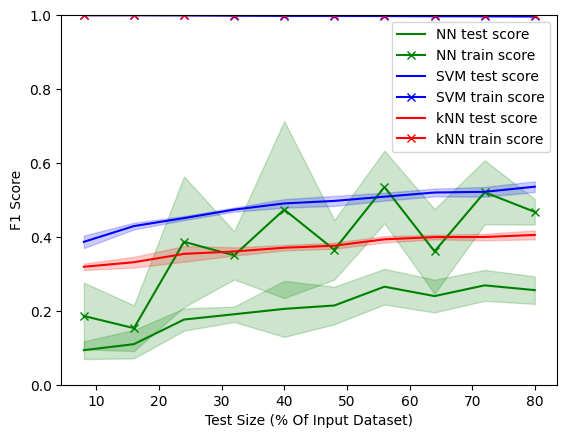

In [71]:
def get_latest_csv_with_prefix(prefix):
    # Define a pattern to match CSV files with the given prefix
    pattern = re.compile(rf'^{prefix}.*\.csv$')
    
    latest_file = None
    latest_time = None

    for filename in os.listdir('.'):
        if pattern.match(filename):
            # Get the timestamp of the file
            timestamp = os.path.getmtime(filename)
            
            # Check if this file has the latest timestamp so far
            if latest_time is None or timestamp > latest_time:
                latest_time = timestamp
                latest_file = filename

    return latest_file

learning_output_df = pd.read_csv(get_latest_csv_with_prefix(f"learning-output-{DATASET_NAME}"))

plt.ylim(0,1)
plt.ylabel("F1 Score")
plt.xlabel("Test Size (% Of Input Dataset)")
for name, df in learning_output_df.groupby("name"):
    plt.plot(df["train_size"]*100, df["test_score"], label=f"{name} test score",color=COLORS[name])
    plt.fill_between(df["train_size"]*100, df["test_score"]+df["test_score_std"],df["test_score"]-df["test_score_std"],alpha=0.2,color=COLORS[name])

    plt.plot(df["train_size"]*100, df["train_score"], marker='x', label=f"{name} train score",color=COLORS[name])
    plt.fill_between(df["train_size"]*100, df["train_score"]+df["train_score_std"],df["train_score"]-df["train_score_std"],alpha=0.2,color=COLORS[name])

plt.legend();

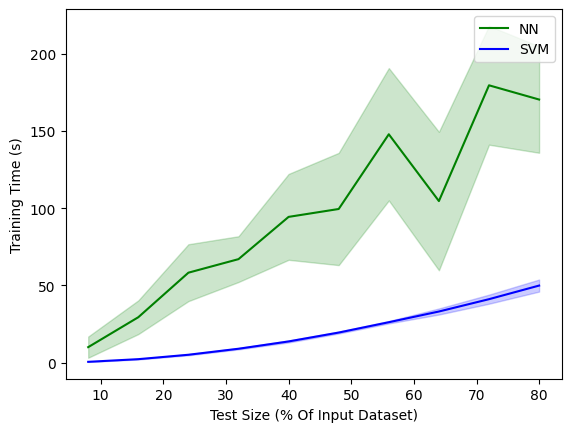

In [73]:
plt.ylabel("Training Time (s)")
plt.xlabel("Test Size (% Of Input Dataset)")
for name, df in learning_output_df.groupby("name"):
    if name not in ("SVM", "NN"):
        continue

    plt.plot(df["train_size"]*100, df["train_time"], label=f"{name}",color=COLORS[name])
    plt.fill_between(df["train_size"]*100, df["train_time"]+df["train_time_std"],df["train_time"]-df["train_time_std"],alpha=0.2,color=COLORS[name])
plt.legend();

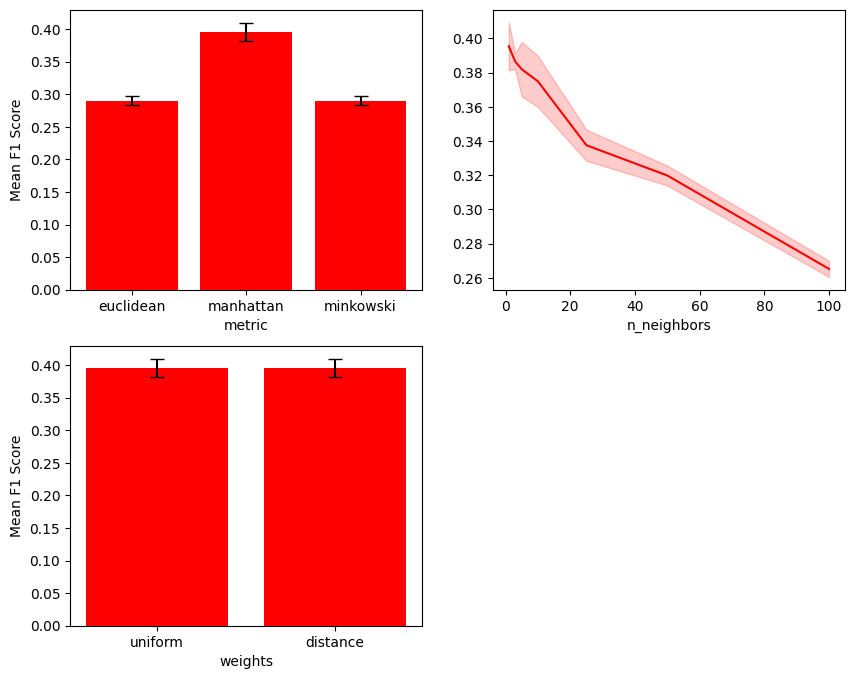

In [143]:
# Begin Validation Curve
def plot_validation_curve(name):
    model_df = pd.read_csv(get_latest_csv_with_prefix(f"{name}-gridsearch-{DATASET_NAME}"))
    model_df['params'] = model_df['params'].apply(lambda x: json.loads(x.replace("'", '"').replace("(", '"(').replace(")", ')"')))

    # Normalize the 'params' column to separate columns
    params_df = pd.json_normalize(model_df['params'])

    # Drop the original 'params' column and merge the new columns
    model_df = model_df.drop(columns=['params']).join(params_df)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    max_i = -1
    for i, (key, value) in enumerate(best_params[name].items()):
        ax = axs.flat[i]
        filtered_df = model_df
        for const_key, const_value in best_params[name].items():
            if const_key==key:
                continue
            if const_key=="hidden_layer_sizes":
                const_value = str(const_value)

            filtered_df = filtered_df[filtered_df[const_key]==const_value]

        ax.set(xlabel=key)
        if key=="hidden_layer_sizes":
            ax.set_xticklabels(filtered_df[key], rotation=45)

        if i % 2==0:
            ax.set(ylabel='Mean F1 Score')

        if filtered_df[key].apply(lambda x: isinstance(x, str)).all():
            ax.bar(filtered_df[key], filtered_df["mean_test_score"], yerr=filtered_df["std_test_score"],capsize=5,color=COLORS[name])
        else:
            ax.plot(filtered_df[key], filtered_df["mean_test_score"], color=COLORS[name])
            ax.fill_between(filtered_df[key], filtered_df["mean_test_score"] + filtered_df["std_test_score"],filtered_df["mean_test_score"] - filtered_df["std_test_score"], color=COLORS[name], alpha=0.2)
        max_i = max(max_i, i)

    for empty_i in range(max_i+1, 4):
        axs.flat[empty_i].axis("off")


plot_validation_curve("kNN")

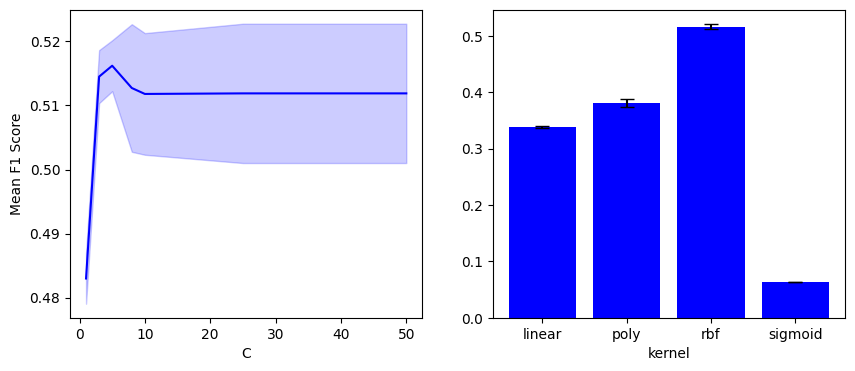

In [142]:
plot_validation_curve("SVM")

/var/folders/v3/kzkfzr0d6vs5bm72nlpk67_c0000gn/T/ipykernel_66426/2458014992.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(filtered_df[key], rotation=45)


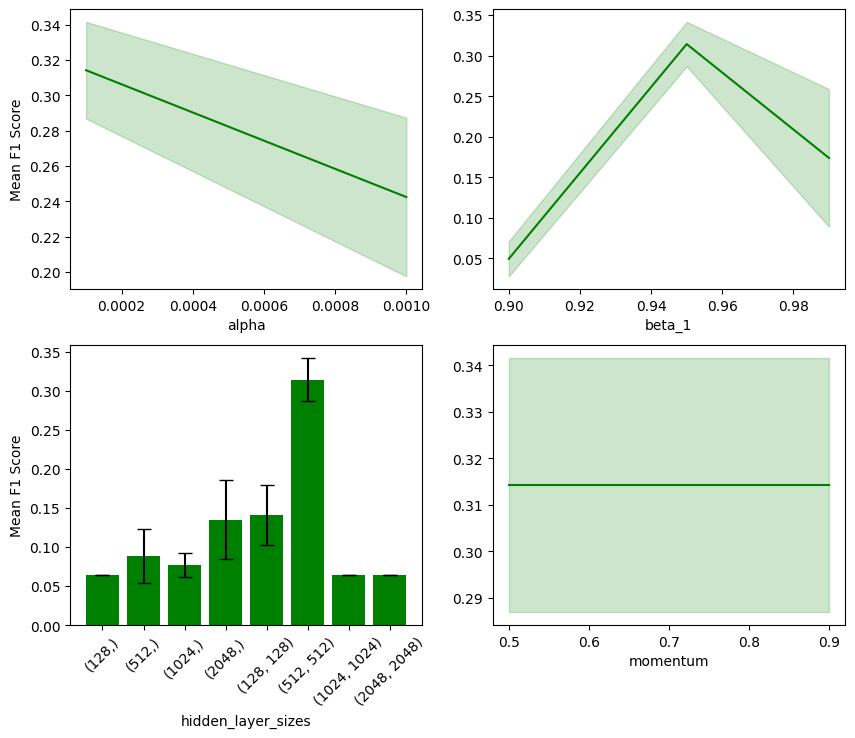

In [119]:
plot_validation_curve("NN")

In [144]:
# Final Evaluation

output = []
for name, model in best_models:
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    output.append([name, f1])

output_df = pd.DataFrame(output, columns=["name", "f1"])

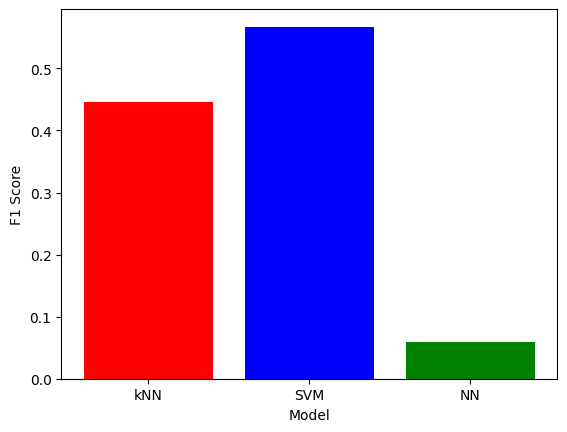

In [145]:
plt.xlabel("Model")
plt.ylabel("F1 Score")

for _, (name, f1) in output_df.iterrows():
    plt.bar(name, f1, color=COLORS[name]);